In [71]:
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
plt.rcParams["figure.figsize"] = (24,5)
import seaborn as sns
sns.set()
sns.set(font_scale=1.75)


In [3]:
cols = [
    "TEST","MAP","SIZE", "TIME"
]
onmodded = pd.read_csv("new_repr.csv", quotechar="'", header=None)

onmodded = onmodded.drop([0],1)
onmodded.columns= cols
onmodded = onmodded.drop([0],0)
onmodded.iloc[:,2:] = onmodded.iloc[:,2:].astype("int32")


styles = {'absl::flat_hash_map': ["#0000cc"],  # blue
          "absl::node_hash_map'": ["#3366ff"],
          'absl::node_hash_map': ["#99ccff"],

          'google::dense_hash_map': ["#ff0000"],  # reds
          'google::sparse_hash_map': ["#ff6666"],
          'phmap::parallel_flat_hash_map': ["#ff0066"],

          'ska::bytell_hash_map': ["#009933"],  # greens
          'ska::flat_hash_map': ["#33cc33"],
          'ska::unordered_map': ["#99ff66"],

          'tsl::hopscotch_map': ["#9900cc"],  # purples
          'tsl::robin_map': ["#cc33ff"],
          'tsl::sparse_map': ["#cc99ff"],

          'robin_hood::unordered_flat_map': ["#ffcc99"],
          'robin_hood::unordered_node_map': ["#ccff66"],

          'boost::unordered::unordered_map': ["#663300"],  # brown

          'emilib::HashMap': ["#9900cc"],  # purple

          # weird orange
          'phmap::parallel_node_hash_map': ["#ffcc66", "solid"],

          'std::unordered_map': ["#000000", "solid"],  # black
         }
ticks = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 500000,
600000, 700000, 800000, 900000, 1000000,
2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000,
15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 45000000, 50000000]
ticklabels = ['50 K', '100 K',
 '150 K', '200 K', '250 K', '300 K',
 '350 K', '400 K', '0.5 M', '0.6 M',
 '0.7 M', '0.8 M', '0.9 M', '1 M',
 '2 M', '3 M', '4 M', '5 M',
 '6 M', '7 M', '8 M', '9 M',
 '10 M', '15 M', '20 M', '25 M',
 '30 M', '35 M', '40 M', '45 M', '50 M']
labels = {
    'int_delete' : ["mean int deletion time", "deletion time (ns)"],
    'int_insert' : ["mean int insertion time", "insertion time(ns)"],
    'int_nosucc_lookup' : ["mean int unsucessful lookup time", "unsucessful lookup time (ns)"],
    'int_succ_lookup' : ["mean int succesful lookup time", "succesful lookup time (ns)"],
    'string_delete' : ["mean string deletion time", "deletion time (ns)"],
    'string_insert' : ["mean string insertion time", "insertion time(ns)"], 
    'string_nosucc_lookup' : ["mean string unsucessful lookup time", "unsucessful lookup time (ns)"],
    'string_succ_lookup' : ["mean string succesful lookup time", "succesful lookup time (ns)"]
}

In [4]:
# outlier testing functions
def remove_with_modified_z_score(data, treshold=3.5):
    # https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
    data = data.astype(int)
    stats = data.describe()
    median_absolute_deviation = abs(data - data.median()).median()
    if not median_absolute_deviation:
        return data
    modified_z_scores = abs(0.6745 * (data - data.median()) / median_absolute_deviation)
    cutoff = modified_z_scores <= treshold
    data = data * cutoff
    data = data.replace(0, nan)
    return data

#function that takes one of the outlier testers and data, and removes outliers
def remove_outlier(data, function):
    new_data = data.copy(True)
    new_data["TIME"] = new_data["TIME"].astype(int)
    new_data["SIZE"] = new_data["SIZE"].astype(int)
    new_data
    for i in range(4216):
        start = i * 30
        end = start+30
        new_data.loc[start:end, "TIME"] = function(data.loc[start:end, "TIME"])
        if not i % 420:
            print(i / 42 , "% done")
    return new_data


# helpers for plot functions
def sort_maps(test):
    maps = data[data["TEST"]== test]["MAP"].unique()
    new = [(groups_max.loc[test, i]["TIME"], i) for i in maps]
    new.sort()
    new = [i[1] for i in new]
    return new

def divider(df, maplist):
    filters = df['MAP'].isin(maplist)
    return df[filters]


def plotter(test, groups):
    maps = sort_maps(test)
    plot_now = [5,11,16]
#     plot_now = [2,5,8,11,14,16]

    for mp in range(0,17):
        map_data = groups.get_group(('int_insert', maps[mp]))        
        sns.lineplot(x="SIZE", y="TIME", data=map_data, err_style="bars", color=styles[maps[mp]][0], label=maps[mp], linestyle="--")
#         sns.regplot(x=map_data["SIZE"], y=map_data["TIME"], color=styles[maps[mp]][0], label=maps[mp])
        if mp in plot_now:
            plt.xscale("log")
            plt.xticks(ticks, ticklabels)
            plt.set_xticklabels(rotation=45)
            plt.ylabel(labels[test][1])
            plt.legend()
            plt.title(labels[test][0])
            plt.show()

def plotter2(test, data):
    mydata = data[data["TEST"] == test]
    maps = sort_maps(test)
    set1 = divider(mydata, maps[:5])
    set2 = divider(mydata, maps[5:11])
    set3 = divider(mydata, maps[11:])
    
    plot = sns.lineplot(x="SIZE", y="TIME", hue="MAP", data=set1)
    plt.xscale("log")
    plt.xticks(ticks, ticklabels)
    plot.set_xticklabels(
        plot.get_xticklabels(), 
        rotation=55, 
        horizontalalignment='center',
        fontweight='light',
    )
    plt.ylabel(labels[test][1])
    plt.legend()
    plt.title(labels[test][0])
    plt.show()
    
    plot = sns.lineplot(x="SIZE", y="TIME", hue="MAP", data=set2)
    plt.xscale("log")
    plt.xticks(ticks, ticklabels)
    plot.set_xticklabels(
        plot.get_xticklabels(), 
        rotation=55, 
        horizontalalignment='center',
        fontweight='light',
        )
    plt.ylabel(labels[test][1])
    plt.legend()
    plt.title(labels[test][0])
    plt.show()
    
    plot = sns.lineplot(x="SIZE", y="TIME", hue="MAP", data=set3)
    plt.xscale("log")
    plt.xticks(ticks, ticklabels)
    plot.set_xticklabels(
        plot.get_xticklabels(), 
        rotation=55, 
        horizontalalignment='center',
        fontweight='light',
    )
    plt.ylabel(labels[test][1])
    plt.legend()
    plt.title(labels[test][0])
    plt.show()

    
def plotter3(test, groups):
    maps = sort_maps(test)
    plot_now = [5,11,16]
#     plot_now = [2,5,8,11,14,16]

    for mp in range(0,17):
        map_data = groups.get_group(('int_insert', maps[mp]))        
#         sns.lineplot(x="SIZE", y="TIME", data=map_data, err_style="band", color=styles[maps[mp]][0], label=maps[mp], linestyle="--")
        sns.regplot(x=map_data["SIZE"], y=map_data["TIME"], color=styles[maps[mp]][0], label=maps[mp])
        if mp in plot_now:
            plt.xscale("log")
            plt.xticks(ticks, ticklabels)
            plt.ylabel(labels[test][1])
            plt.legend()
            plt.set_xticklabels(rotation=45)
            plt.title(labels[test][0])
            plt.show()


In [5]:
data = remove_outlier(onmodded, remove_with_modified_z_score)
groups = data.groupby(["TEST", "MAP"])
gr_max = groups.max()
gr_mean = groups.mean()

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100.0 % done


In [5]:
tests = data["TEST"].unique()
# for i in tests:
#     plotter2(i, data)

In [6]:
# for i in tests:
#     plotter(i, groups)


In [7]:
# for i in tests:
#     plotter3(i, groups)

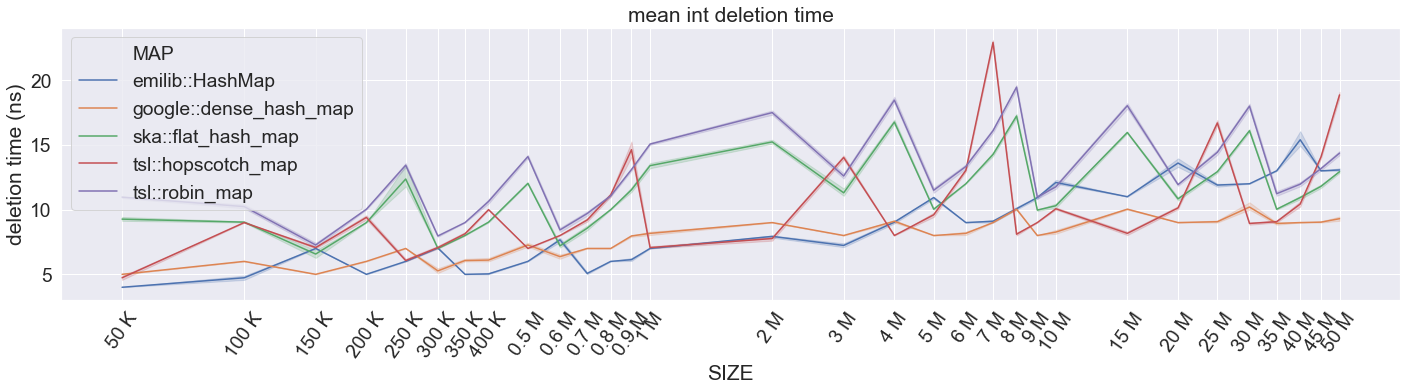

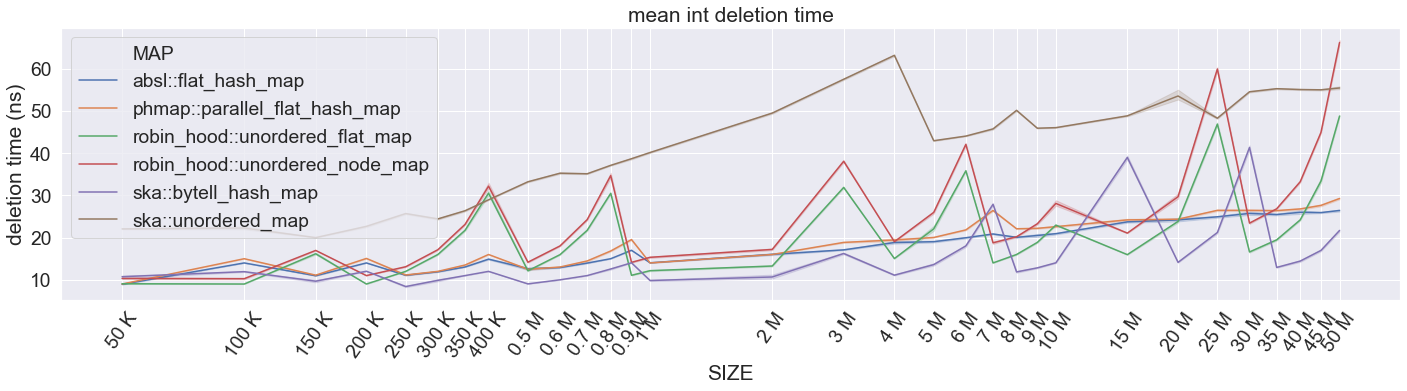

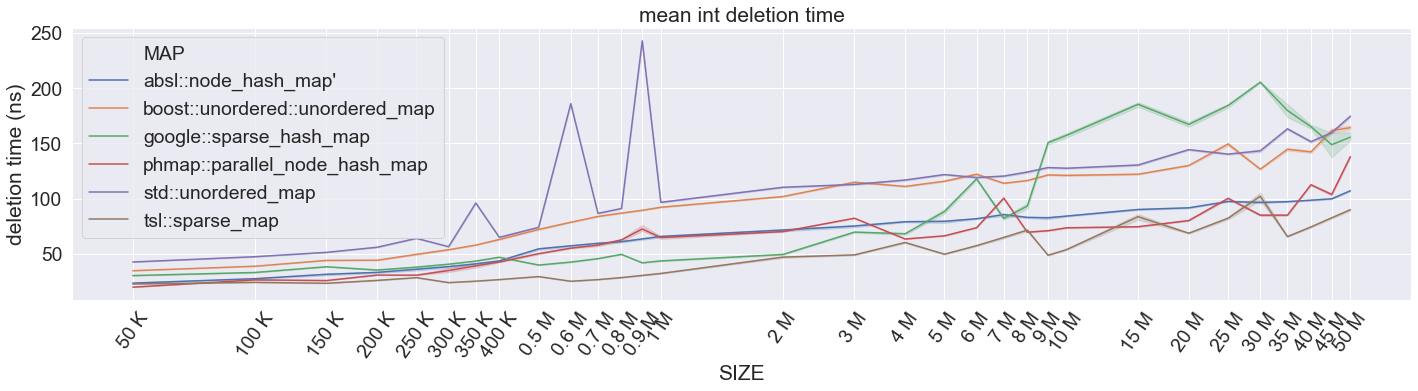

In [8]:
plotter2(tests[0], data)

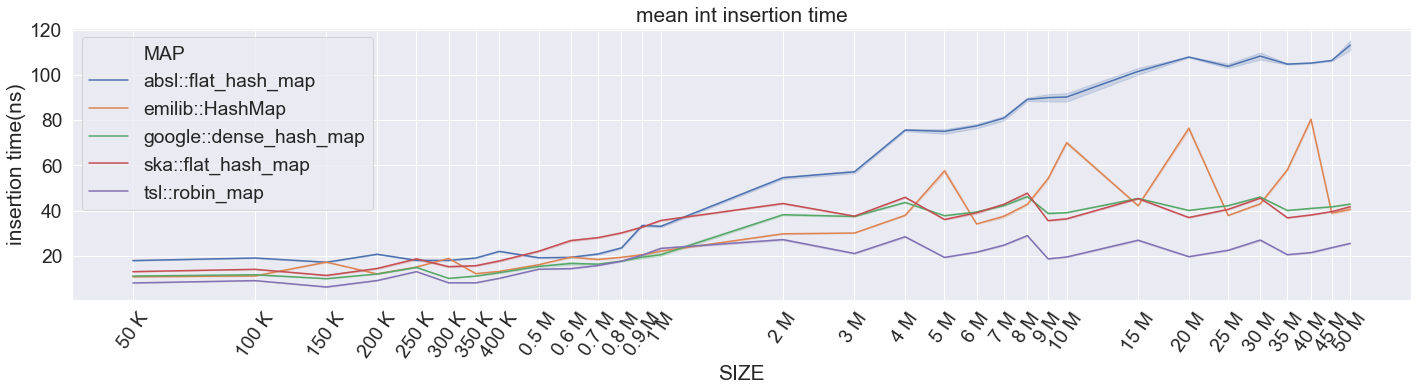

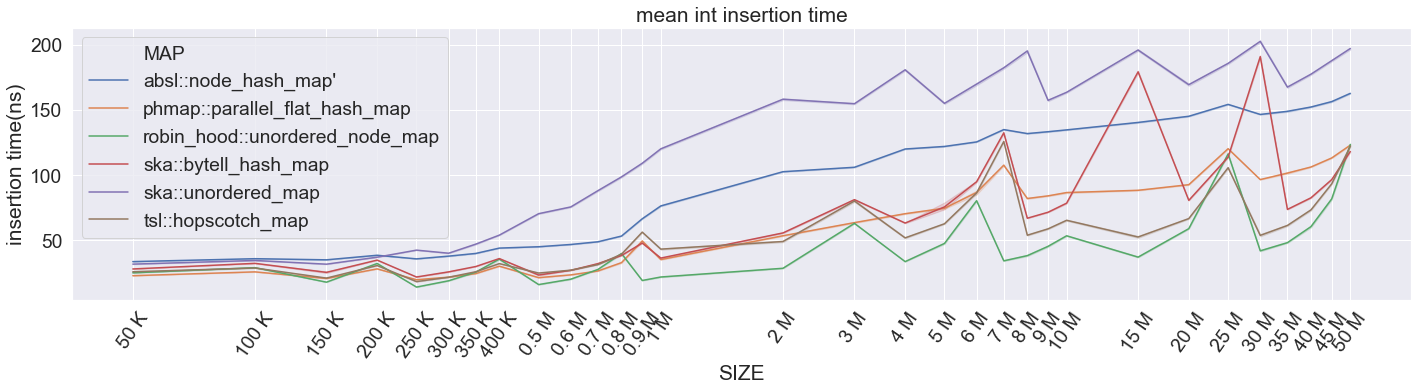

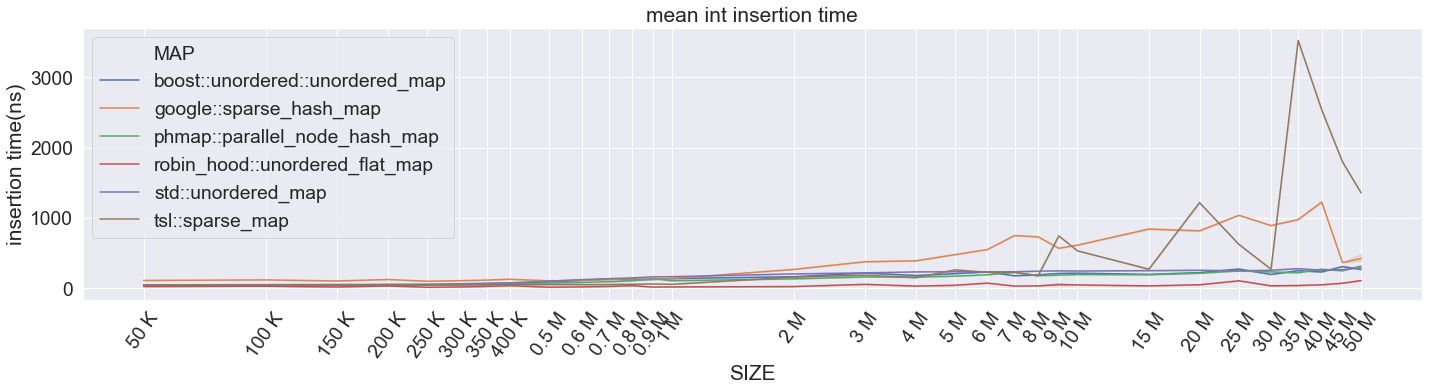

In [9]:
plotter2(tests[1], data)

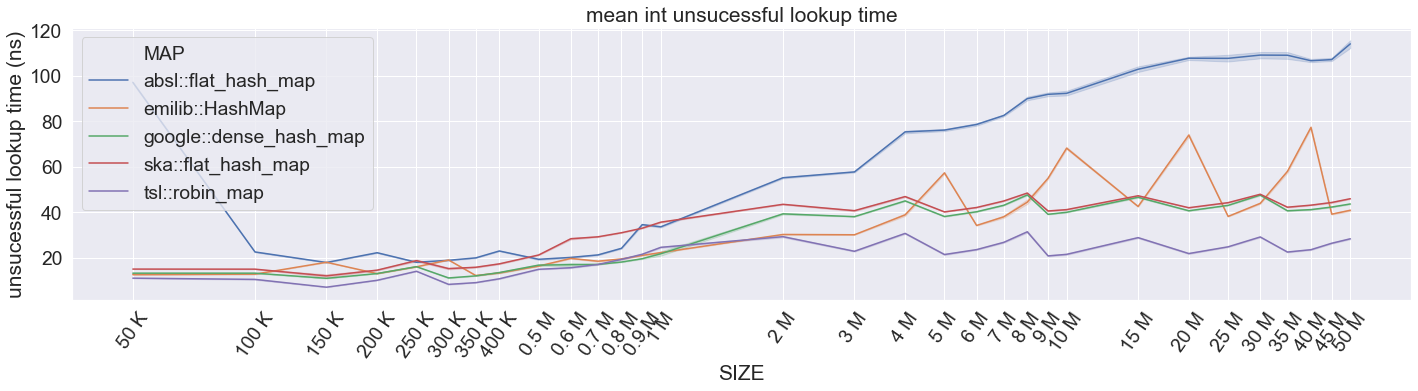

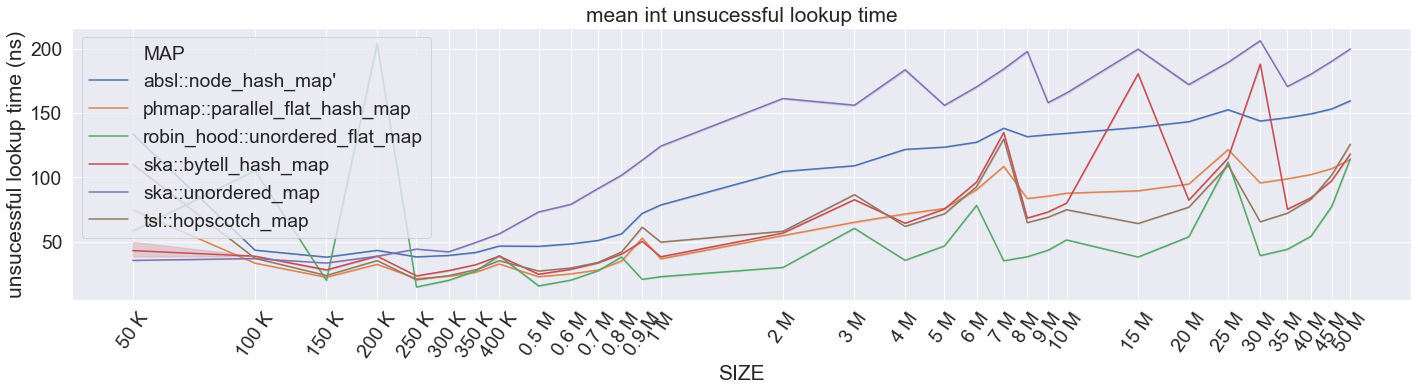

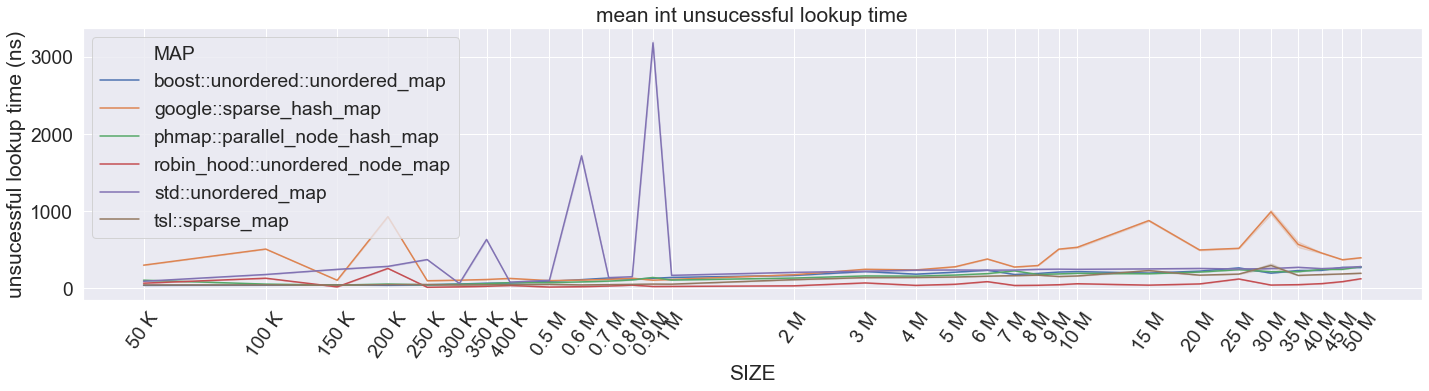

In [10]:
plotter2(tests[2], data)

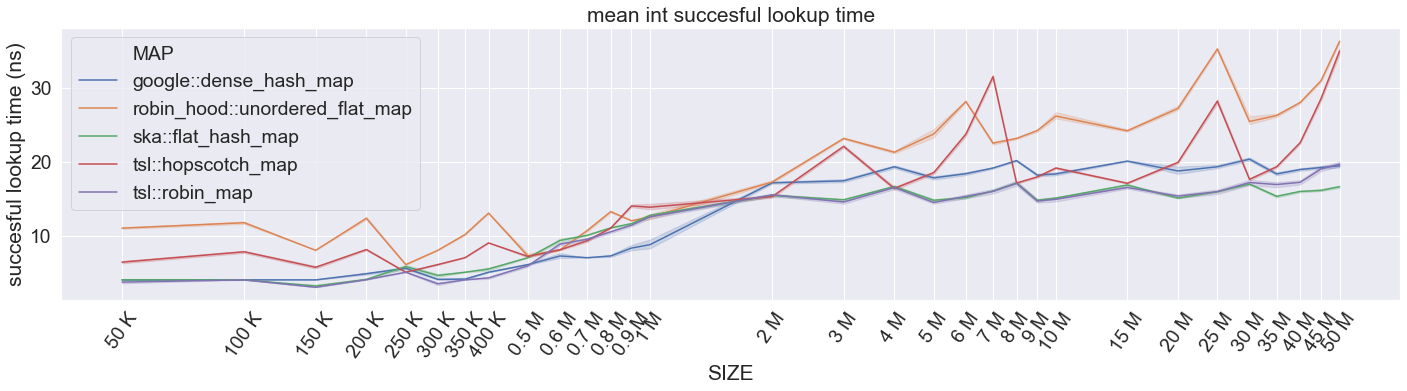

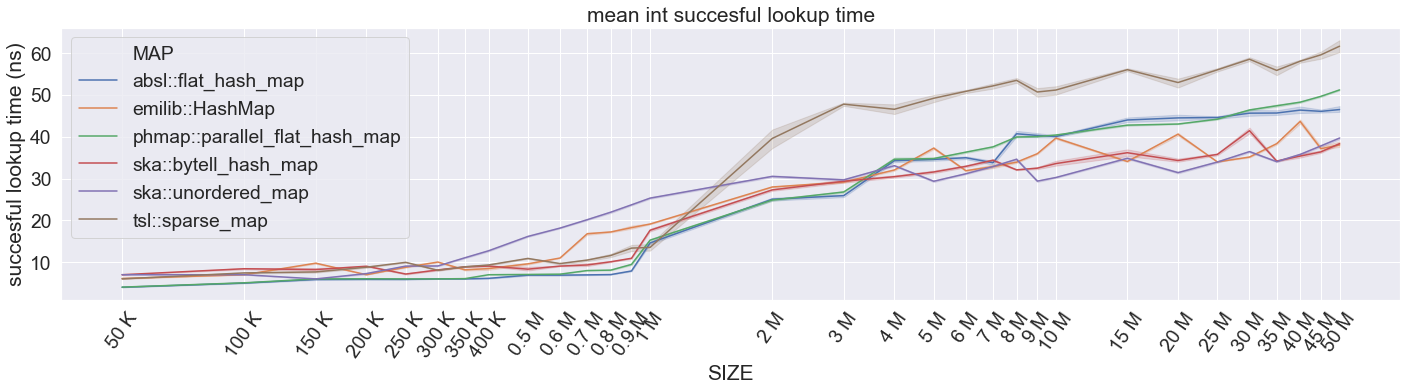

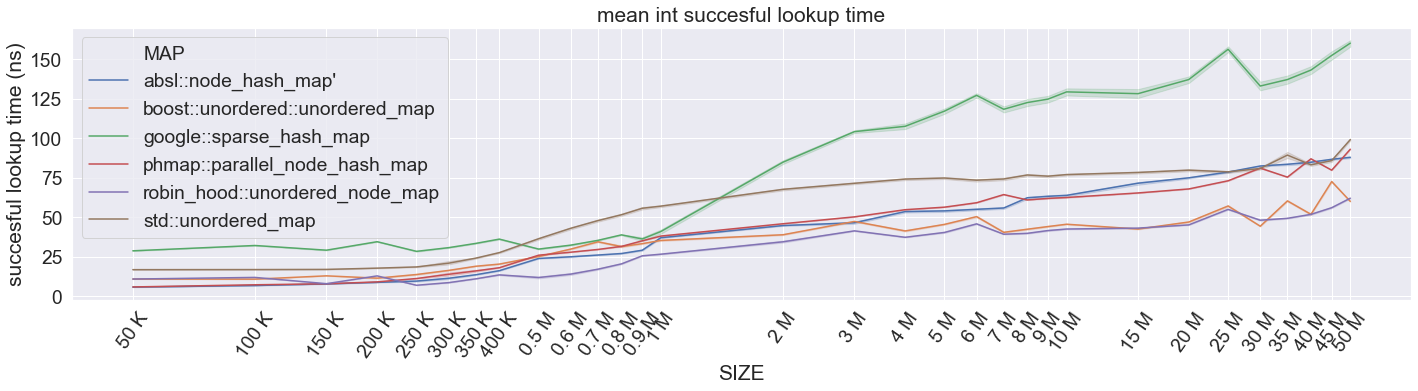

In [11]:
plotter2(tests[3], data)

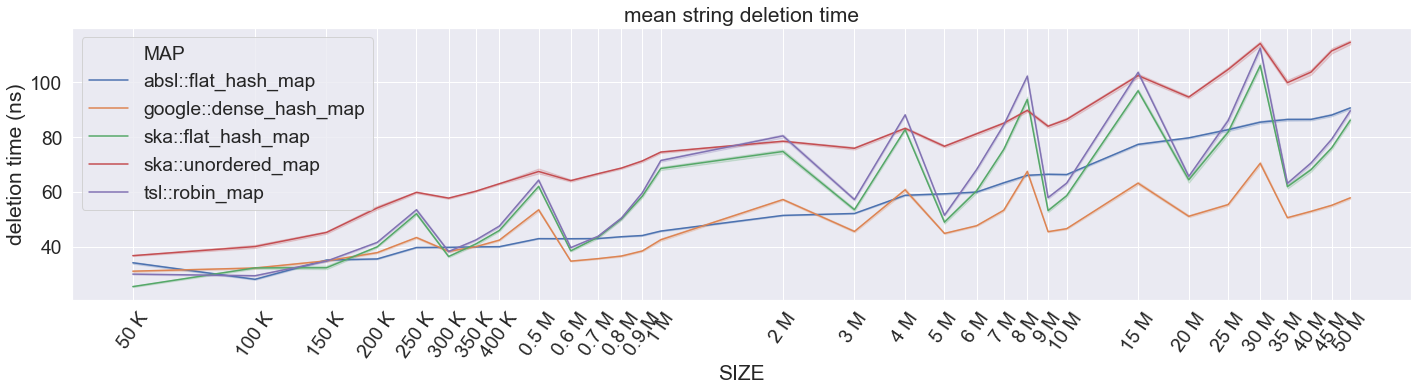

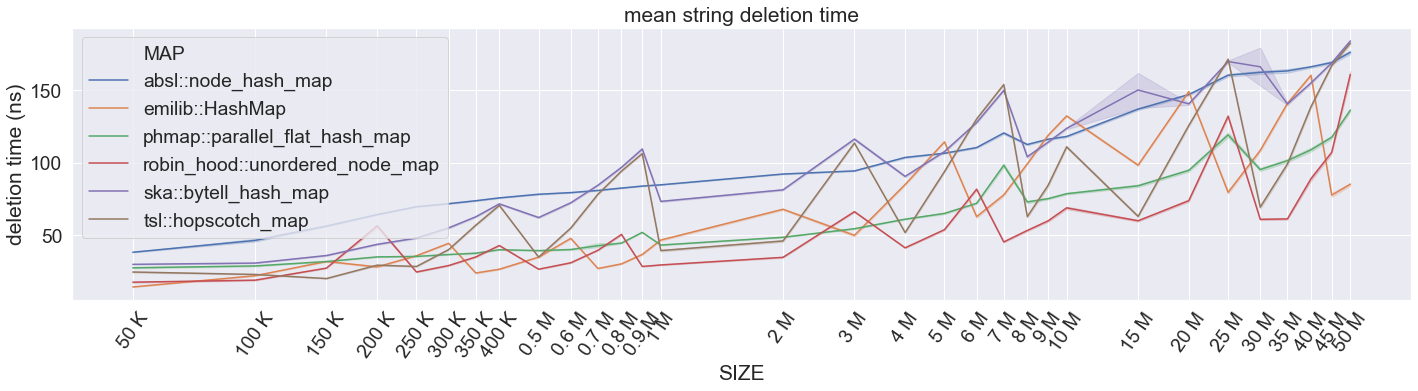

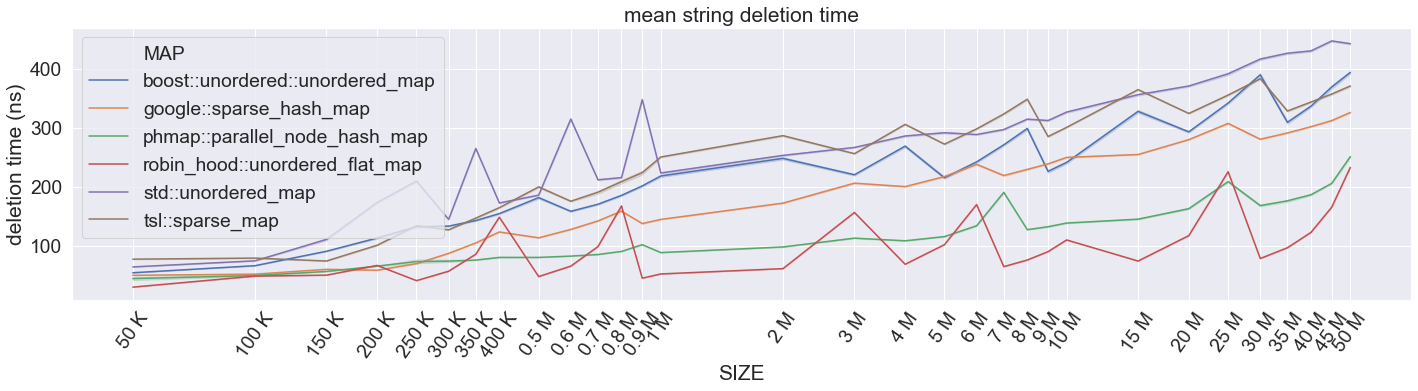

In [12]:
plotter2(tests[4], data)

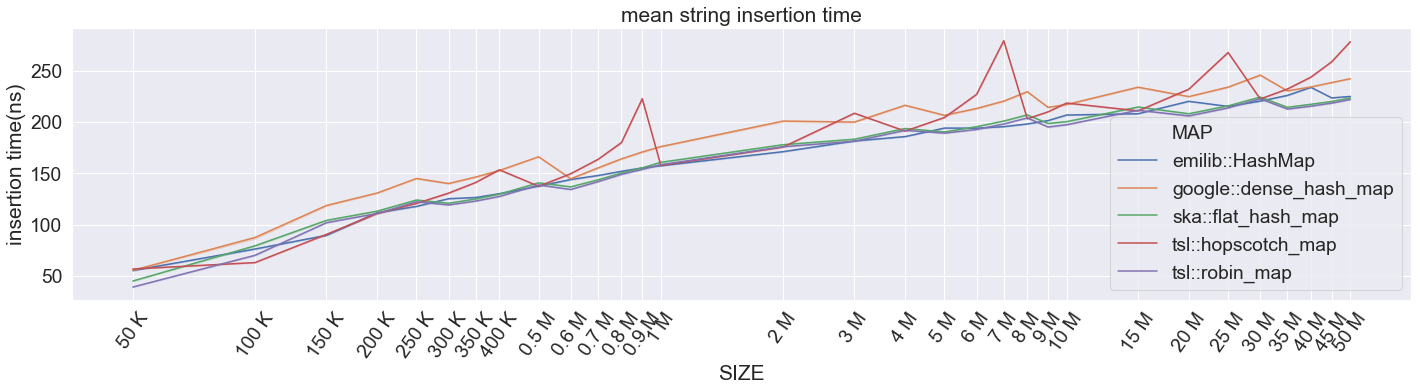

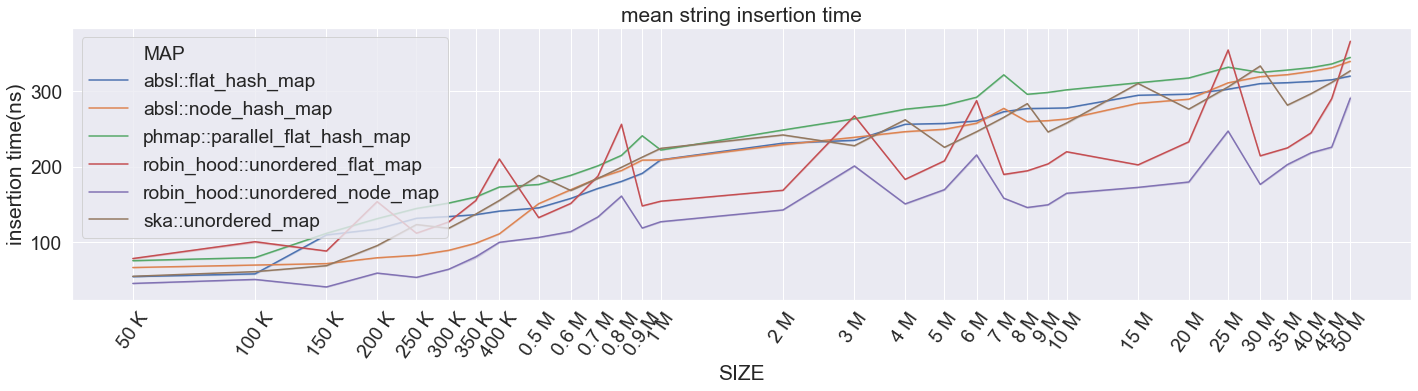

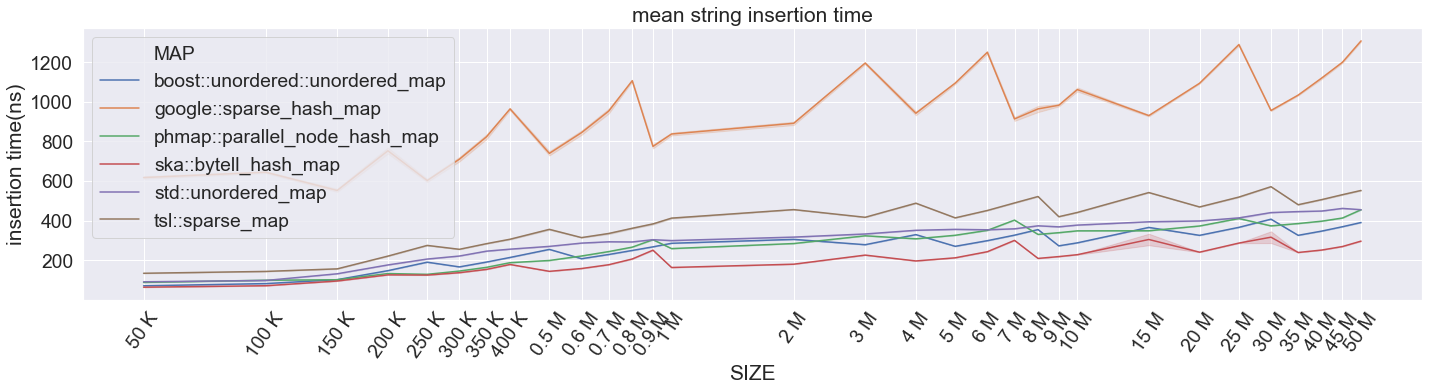

In [13]:
plotter2(tests[5], data)

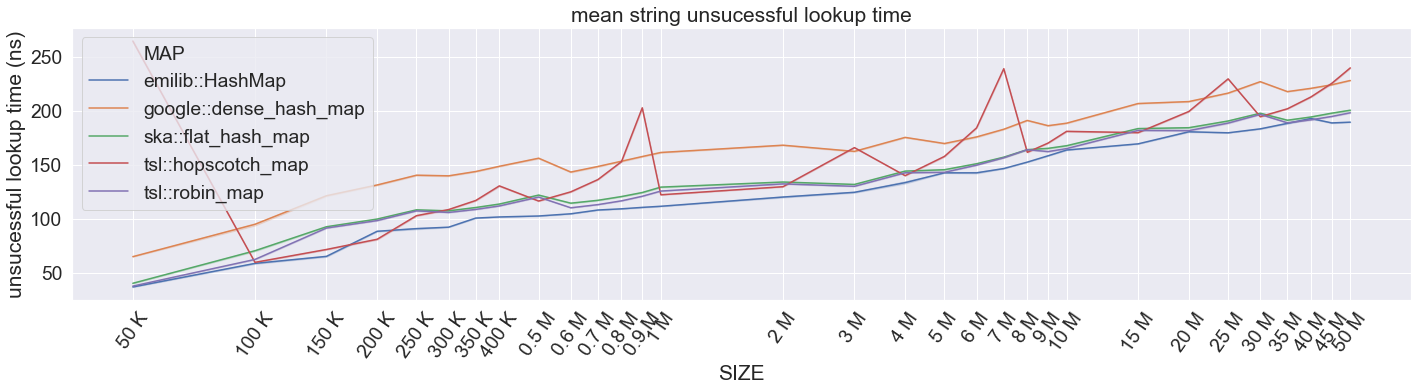

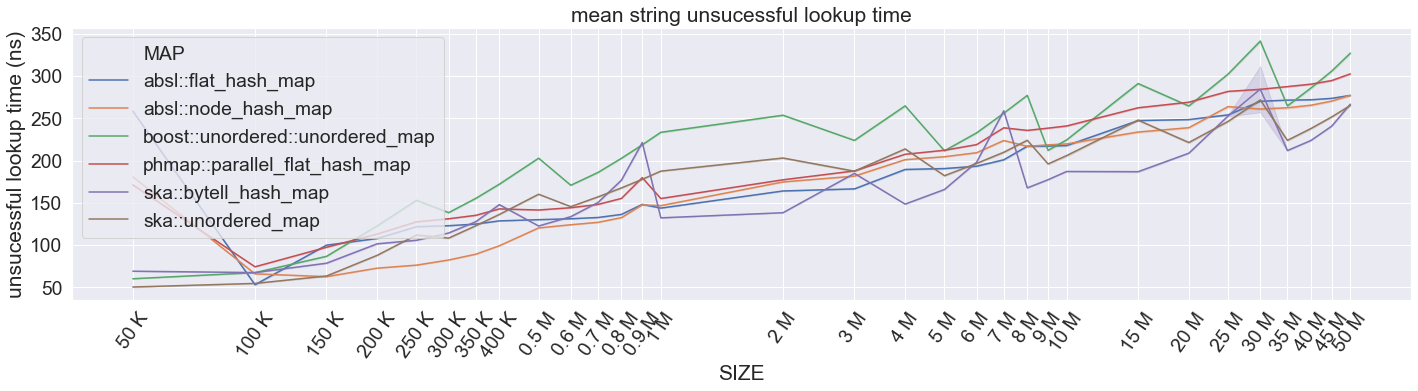

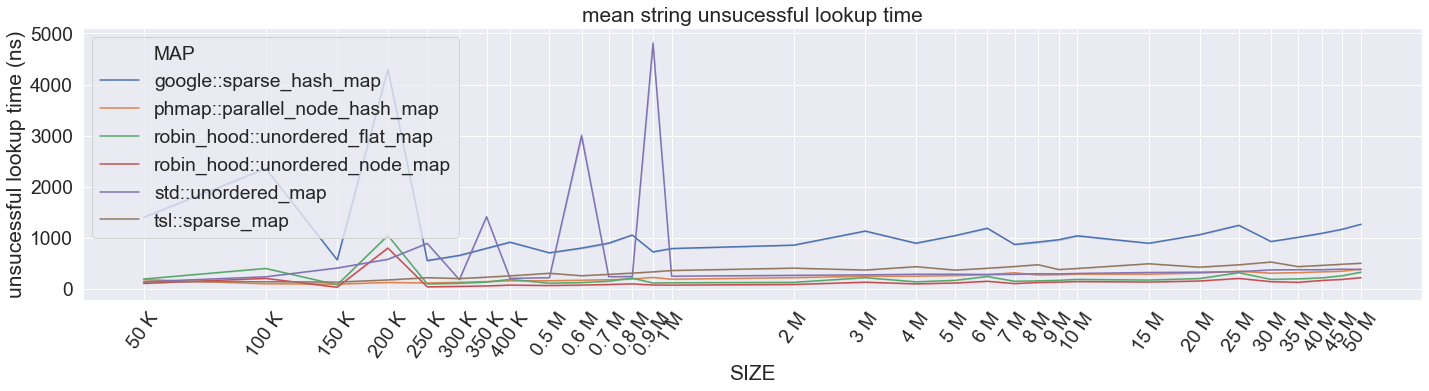

In [14]:
plotter2(tests[6], data)

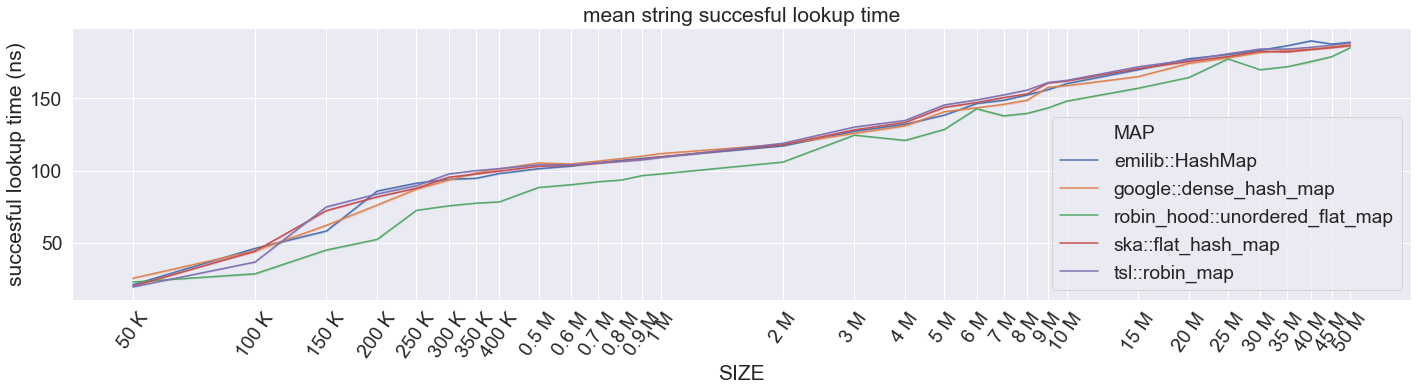

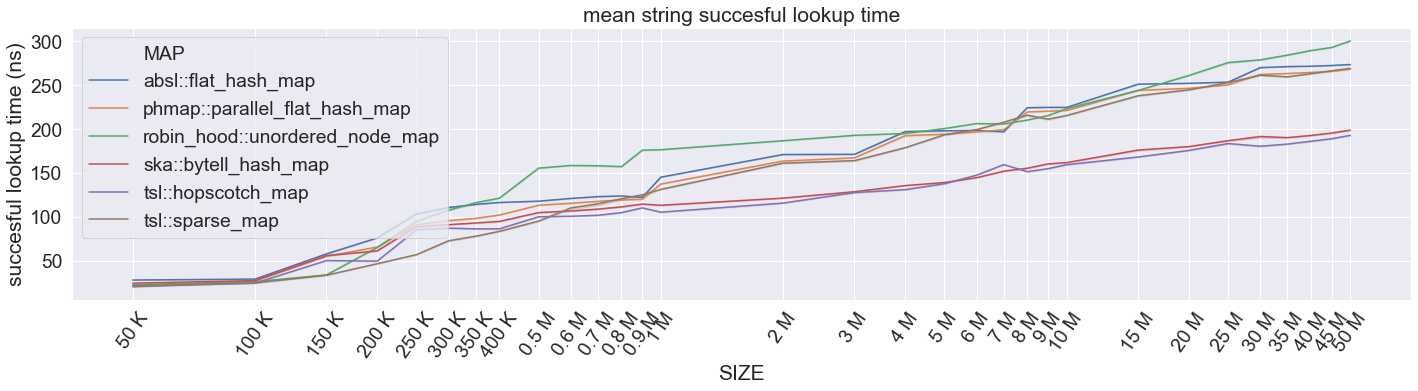

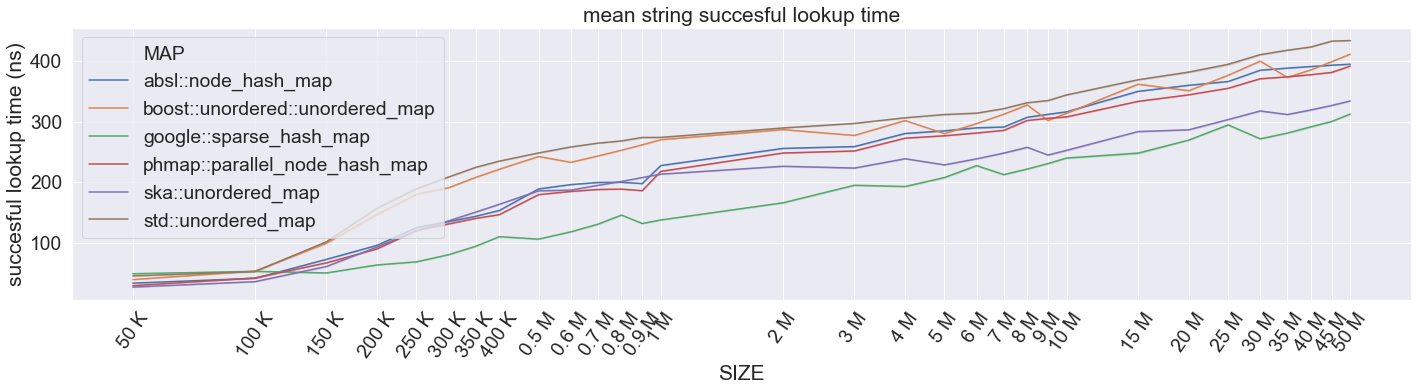

In [15]:
plotter2(tests[7], data)

In [18]:
data["MAP"].unique()

array(['absl::flat_hash_map', "absl::node_hash_map'",
       'boost::unordered::unordered_map', 'emilib::HashMap',
       'google::dense_hash_map', 'google::sparse_hash_map',
       'phmap::parallel_flat_hash_map', 'phmap::parallel_node_hash_map',
       'robin_hood::unordered_flat_map', 'robin_hood::unordered_node_map',
       'ska::bytell_hash_map', 'ska::flat_hash_map', 'ska::unordered_map',
       'std::unordered_map', 'tsl::hopscotch_map', 'tsl::robin_map',
       'tsl::sparse_map', 'absl::node_hash_map'], dtype=object)

In [40]:
test = "string_insert"
alpha_maps = gr_mean.loc[test]["TIME"].index
rank = list(gr_mean.loc[test]["TIME"].sort_values().index)
rank = [rank.index(i) for i in alpha_maps]
for i in rank:
    print(i + 1)

11
9
13
4
6
17
12
14
7
1
8
3
10
15
5
2
16


array(['int_delete', 'int_insert', 'int_nosucc_lookup', 'int_succ_lookup',
       'string_delete', 'string_insert', 'string_nosucc_lookup',
       'string_succ_lookup'], dtype=object)

In [51]:
tests = data["TEST"].unique()
alpha_maps = gr_mean.loc[test]["TIME"].index
total_rank = pd.Series([0 for i in range(17)]) 

for test in tests:
    alpha_maps = gr_mean.loc[test]["TIME"].index
    rank = list(gr_mean.loc[test]["TIME"].sort_values().index)
    rank = Series([rank.index(i) + 1 for i in alpha_maps])
    total_rank += rank
total_rank.index = alpha_maps
print(total_rank.sort_values())

MAP
google::dense_hash_map              25
tsl::robin_map                      25
ska::flat_hash_map                  28
emilib::HashMap                     32
tsl::hopscotch_map                  43
robin_hood::unordered_node_map      50
robin_hood::unordered_flat_map      54
ska::bytell_hash_map                64
absl::flat_hash_map                 65
phmap::parallel_flat_hash_map       74
ska::unordered_map                  84
absl::node_hash_map                 94
tsl::sparse_map                    108
phmap::parallel_node_hash_map      110
boost::unordered::unordered_map    115
google::sparse_hash_map            123
std::unordered_map                 130
dtype: int64


In [89]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [116]:
test = data[data["TEST"] == "int_delete"]
test = data[data["MAP"] == "google::dense_hash_map" ]
test = test.dropna()
test["TIME"] = test["TIME"].astype(int)
test["SIZE"] = test["SIZE"].astype(int)
test["SIZE2"] = np.log(test["SIZE"])

# test["SIZE2"] = test["SIZE"]
# model = smf.ols("TIME~SIZE + SIZE2",data=test)

model = sm.OLS(test["TIME"], test[["SIZE", "SIZE2"]])
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   TIME   R-squared (uncentered):                   0.547
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              4423.
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                        0.00
Time:                        11:06:23   Log-Likelihood:                         -41641.
No. Observations:                7331   AIC:                                  8.329e+04
Df Residuals:                    7329   BIC:                                  8.330e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

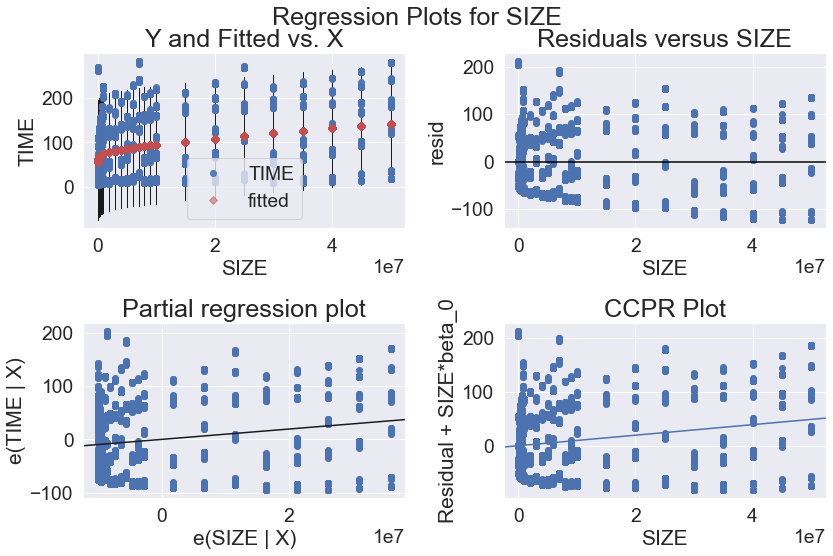

PatsyError: Error evaluating factor: NameError: name 'SIZE3' is not defined
    SIZE3
    ^^^^^

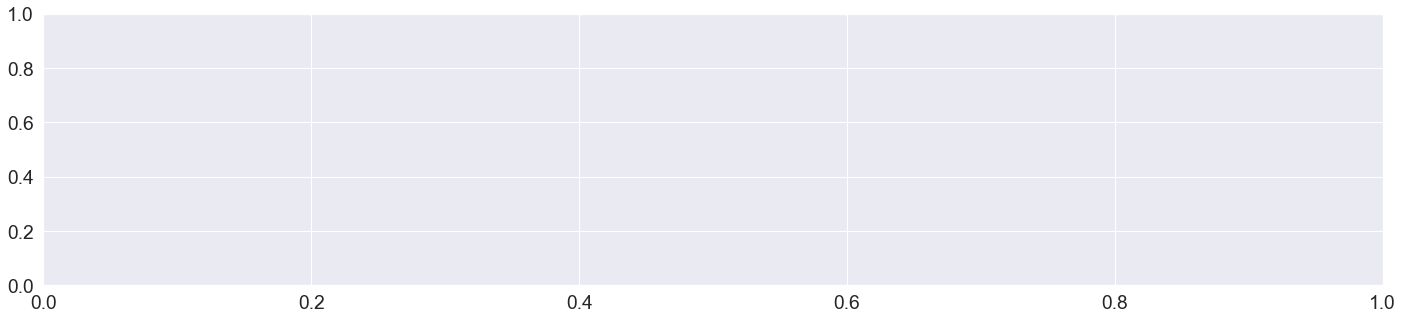